# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [1]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

# import local copy of cvxpower
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from cvxpower import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
#matplotlib.rc("font", serif='Computer Modern Roman')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

graphdir = './'
figsize=(8,5)

## Load predictive model 

In [2]:
baseline = pd.read_pickle('wind_baseline.pickle')
autoreg_residual_params = pd.read_pickle('residual_params.pickle')
sigma_residual_errors = pd.read_pickle('sigma_epsilon.pickle')
train = pd.read_pickle('wind_power_train.pickle')
test = pd.read_pickle('wind_power_test.pickle')
p_wind = pd.concat([train,test])
del train
del test

## Set constants and test period

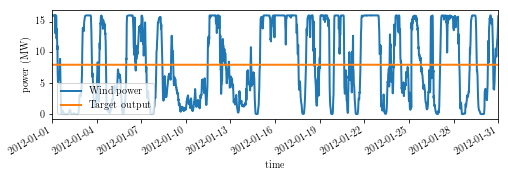

In [3]:
# CONSTANTS
storage_capacity = 100 # MWh
initial_storage = storage_capacity // 2
battery_charge_max = storage_capacity /10. # a full charge in 10 hours
battery_discharge_max = storage_capacity /10. # a full discharge in 10 hours
wind_power_max = 16.  # TODO delete?
wind_power_min = 0.  # TODO delete?

gas_power_max = 10  #MW
gas_power_min = 0.01 #MW
gas_alpha = .5
gas_beta = 40.

# len of each time interval, in hours
len_interval = (baseline.index[1] - baseline.index[0]).seconds/3600
intervals_per_day = int(24 / len_interval)

# analysis horizon
T = intervals_per_day * 31

# we test on the first off-sample month
sim_start_time = 70080 # Timestamp('2012-01-01 00:00:00')
sim_end_time = sim_start_time + T

assert len(baseline) > sim_end_time
assert baseline.index[sim_start_time].year >= 2012 # out of sample

MPC_final_energy_price = 80 / len_interval


#wind_power_available = test[target_output.index]

target_output = pd.Series(data= 8., #baseline[sim_start_time:sim_end_time].mean(),
                          index=baseline[sim_start_time:sim_start_time + 2*T].index)

#p_wind[sim_start_time:sim_end_time].plot(figsize=(12,3), label='Wind power')
plt.figure(figsize=(8,3))
plt.subplot2grid((4,1), (0,0), rowspan=3)
y = p_wind[sim_start_time:sim_end_time]
plt.plot(y.index, y.values, label='Wind power')
target_output[:T].plot(label='Target output')
plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
plt.ylabel('power (MW)')
plt.xlabel('time')

plt.legend(loc='lower left')
plt.savefig('wind_data.pdf')

### Cost of MWh produced by gas turbine 

Text(0,0.5,'\\$ / MWh')

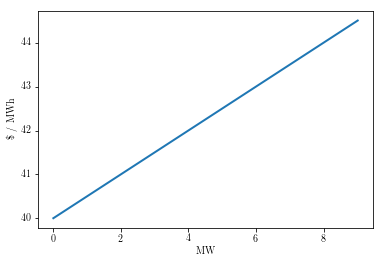

In [4]:
def cost_per_unit(power):
    return (gas_alpha * power**2 + gas_beta * power)/power

x = np.arange(gas_power_min, gas_power_max, gas_power_max/10)
plt.plot(x, cost_per_unit(x))
plt.xlabel('MW')
plt.ylabel('\$ / MWh')

## Prescient DOPF

In [5]:
def make_network(T, K):
    """Define network and parameters for data."""
    target_output = Parameter((T,K))
    wind_power_available = Parameter((T,K))
    initial_storage = Parameter((1,1))
    final_energy_price = Parameter((1,1))
    final_storage = Parameter((1,1))
    out = FixedLoad(power = target_output, name="Target output")
    wind_gen = Generator(alpha=0, beta=0, power_min=0, 
                         power_max=wind_power_available, name="Wind generator")
    gas_gen = Generator(alpha=gas_alpha, beta=gas_beta, 
                        power_min=gas_power_min, power_max=gas_power_max, name="Gas generator",
                       len_interval = len_interval)
    storage = Storage(discharge_max=battery_discharge_max, charge_max=battery_charge_max, 
                      energy_max=storage_capacity, 
                      energy_init = initial_storage, 
                      energy_final = final_storage,
                     len_interval = len_interval,
                     final_energy_price = final_energy_price)
    net = Net([wind_gen.terminals[0],
               gas_gen.terminals[0],
               storage.terminals[0],
               out.terminals[0]])
    my_network = Group([wind_gen, gas_gen, storage, out], [net])
    my_network.init_problem(time_horizon=T, num_scenarios = K)
    return target_output, wind_power_available, initial_storage, final_storage, final_energy_price, my_network

In [6]:
target_output_par, wind_power_available_par, initial_storage_par, final_storage_par, final_energy_price, dopf_network = \
    make_network(T, 1)
    
target_output_par.value = np.matrix(target_output[:T]).T
wind_power_available_par.value = np.matrix(p_wind[sim_start_time:sim_end_time]).T
initial_storage_par.value = np.matrix(initial_storage)
final_storage_par.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(0.)

cost_dopf = dopf_network.problem.solve(solver='ECOS', verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +5.180e+05  -4.165e+06  +6e+06  6e-02  6e-02  1e+00  2e+02    ---    ---    1  1  - |  -  - 
 1  +3.896e+05  -3.568e+06  +5e+06  5e-02  4e-02  6e+01  2e+02  0.4908  5e-01   2  2  2 |  0  0
 2  +2.439e+05  -8.716e+05  +1e+06  1e-02  1e-02  5e+01  5e+01  0.8914  2e-01   1  1  1 |  0  0
 3  +2.386e+05  -8.454e+05  +1e+06  1e-02  1e-02  5e+01  4e+01  0.1291  7e-01   2  2  2 |  0  0
 4  +1.855e+05  -5.105e+05  +8e+05  8e-03  7e-03  3e+01  3e+01  0.7506  5e-01   1  2  1 |  0  0
 5  +1.439e+05  -1.856e+05  +4e+05  4e-03  3e-03  2e+01  1e+01  0.6151  2e-01   1  1  1 |  0  0
 6  +1.454e+05  -1.478e+05  +4e+05  3e-03  3e-03  1e+01  1e+01  0.3039  6e-01   1  1  1 |  0  0
 7  +1.289e+05  +1.782e+04  +1e+05  1e-03  1e-03  5e+00  5e+00  0.7187  1e-01   1  1  1 |  0  0
 8  +1.289e+05  +2.290e+04  +1e+05  1e-03  1e-

In [7]:
def print_and_plot_stats(wind_power_avail, wind_power_used, gas_power, output, cost):
    assert len(output) == len(wind_power_avail)
    assert len(output) == len(wind_power_used)
    assert len(output) == len(gas_power)

    plt.figure(figsize=(9,3.5))
    plt.subplot2grid((10,1), (0,0), rowspan=9)
    plt.plot(wind_power_avail.index, wind_power_avail.values, label='avail.', alpha=.8)
    pd.Series(data = wind_power_used, 
              index = wind_power_avail.index).plot(label='used', alpha=.8)
    #output.plot(label='target', style='--', color='k', alpha=.8)
    plt.legend(loc='lower left')
    plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
    plt.ylabel('Power (MW)')
    plt.xlabel('time')
    #plt.gcf().autofmt_xdate()
    plt.savefig('wind_curtailment.pdf')

    total_output = sum(output)/len(output) 
    total_wind_power_avail = sum(wind_power_avail)/len(output)
    total_gas_gen = sum(gas_power)/len(output)

    print('(Values are daily averages.)\n')
    print('Energy sold:\t\t%.2f MWh\nWind energy avail.:\t%.2f MWh\nGas gener. output:\t%.2f MWh\nWind energy used:\t%.2f MWh\nWind energy lost:\t%.2f MWh' % (
        24*total_output,
        24*total_wind_power_avail,
        24*total_gas_gen,
        24*np.mean(wind_power_used),
        24*(total_wind_power_avail - np.mean(wind_power_used))
    ))

    print('\nEnergy sold (at $80/MWh):    $%.2f' % (24 * total_output *80))
    print('Cost of gas generated energy:  $%.2f' % (24 * cost / (len(output))))

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	23.09 MWh
Wind energy used:	168.91 MWh
Wind energy lost:	33.45 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $958.96


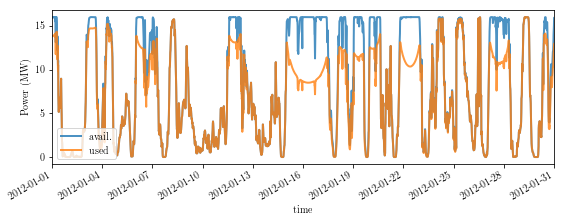

In [8]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]


print_and_plot_stats(wind_power_avail = p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -dopf_network.results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -dopf_network.results.power[(gas_gen,0)], 
                     output = target_output[:T], 
                     cost = cost_dopf)

In [9]:
import pandas as pd
#high_level = ['prescient', 'MPC, exact pred.', 'MPC, uncert. pred.']
#low_level = ['avg.', 'st. dev.']
flows = pd.DataFrame()#columns=pd.MultiIndex.from_product([high_level, low_level], names=['', '']))
for (device, terminal) in dopf_network.results.power.keys():
    #print(np.mean(dopf_network.results.power[(device, terminal)]))
    flows.loc[device.name, 'prescient'] = np.mean(dopf_network.results.power[(device, terminal)])
    #flows.loc[device.name, ('prescient','st. dev.')] = np.std(dopf_network.results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))


prices = pd.DataFrame()
for net in dopf_network.results.price.keys():
    prices.loc[net.name, 'prescient'] = np.mean(dopf_network.results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.2f' % x))


payments = pd.DataFrame()
for (device, terminal) in dopf_network.results.payments.keys():
    payments.loc[device.name, 'prescient'] = np.sum(dopf_network.results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))



\begin{tabular}{lr}
\toprule
{} &  prescient \\
\midrule
Wind generator &    -7.04MW \\
Gas generator  &    -0.96MW \\
Storage        &    -0.00MW \\
Target output  &     8.00MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  prescient \\
\midrule
Net &     \$19.24 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  prescient \\
\midrule
Wind generator &    \$-52366 \\
Gas generator  &    \$-30658 \\
Storage        &    \$-31470 \\
Target output  &    \$114495 \\
\bottomrule
\end{tabular}



In [10]:
def plot(results, target_output, energy_stored, methodname):
    ax = results.plot(figsize=(9,3.5), index=target_output.index)
    plt.subplots_adjust(hspace=0.075)
    ax[0].set_ylabel('power (MW)')
    ax[0].set_xlim(['01-01-2012', '01-31-2012'])
    ax[0].legend(['gen.', 'batt.', 'target', 'wind'], loc='lower left')
    ax[0].tick_params(axis="x", which="both", bottom="off", top="off",
                  labelbottom="off", left="off", right="off", labelleft="off")
    ax[1].clear() 
    ax[1].plot(target_output.index, energy_stored)
    ax[1].set_ylabel('Energy (MWh)')
    ax[1].set_xlim(['01-01-2012', '01-31-2012'])
    ax[1].set_ylim([0, 50])
    plt.xlabel('time')
    plt.savefig(graphdir+'wind_%s_results.pdf'%methodname)

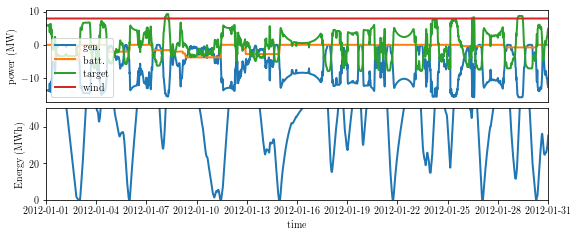

In [11]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

plot(dopf_network.results, baseline[sim_start_time:sim_end_time], storage.energy.value, 'dopf')

## Prescient MPC 

In [12]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [04:43<00:00, 10.62it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	25.18 MWh
Wind energy used:	167.67 MWh
Wind energy lost:	34.69 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1050.06


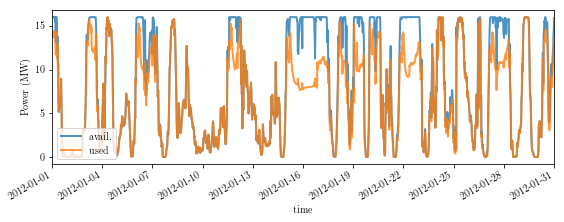

In [13]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)

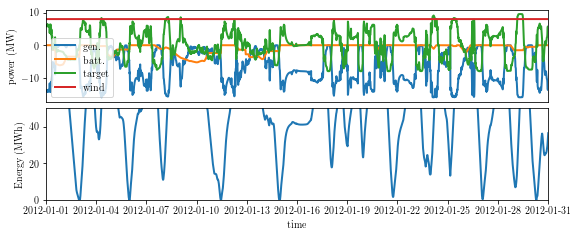

In [14]:
plot(prescient_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'presc_mpc')

In [15]:
for (device, terminal) in prescient_MPC_results.power.keys():
    flows.loc[device.name, 'exact MPC'] = np.mean(prescient_MPC_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, exact pred.','st. dev.')] = np.std(prescient_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))

for net in prescient_MPC_results.price.keys():
    prices.loc[net.name, 'exact MPC'] = np.mean(prescient_MPC_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.2f' % x))

for (device, terminal) in prescient_MPC_results.payments.keys():
    payments.loc[device.name, 'exact MPC'] = np.sum(prescient_MPC_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrr}
\toprule
{} &  prescient &  exact MPC \\
\midrule
Wind generator &    -7.04MW &    -6.99MW \\
Gas generator  &    -0.96MW &    -1.05MW \\
Storage        &    -0.00MW &     0.04MW \\
Target output  &     8.00MW &     8.00MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  prescient &  exact MPC \\
\midrule
Net &     \$19.24 &     \$19.82 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  prescient &  exact MPC \\
\midrule
Wind generator &    \$-52366 &    \$-66994 \\
Gas generator  &    \$-30658 &    \$-33718 \\
Storage        &    \$-31470 &    \$-17263 \\
Target output  &    \$114495 &    \$117974 \\
\bottomrule
\end{tabular}



## MPC with baseline and residual AR

In [16]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred = np.maximum(wind_power_min, pred + fut_baseline)
    pred = np.minimum(wind_power_max, pred + fut_baseline)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [04:06<00:00, 12.05it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	44.12 MWh
Wind energy used:	146.26 MWh
Wind energy lost:	56.09 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1903.52


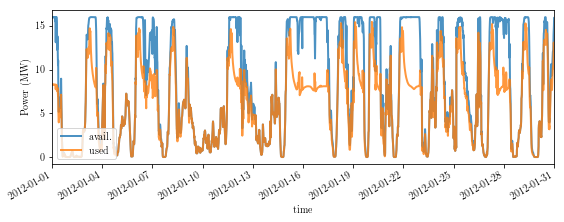

In [17]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC)

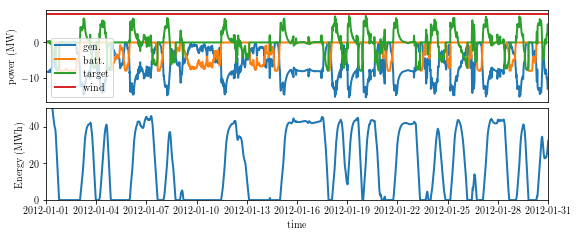

In [18]:
plot(AR_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'AR_mpc')

In [23]:
for (device, terminal) in AR_MPC_results.power.keys():
    flows.loc[device.name, 'uncert. MPC'] = np.mean(AR_MPC_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, uncert. pred.','st. dev.')] = np.std(AR_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.0fMW' % x))

for net in AR_MPC_results.price.keys():
    prices.loc[net.name, 'uncert. MPC'] = np.mean(AR_MPC_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

for (device, terminal) in AR_MPC_results.payments.keys():
    payments.loc[device.name, 'uncert. MPC'] = np.sum(AR_MPC_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  exact MPC &  uncert. MPC \\
\midrule
Wind generator &       -7MW &       -7MW &         -6MW \\
Gas generator  &       -1MW &       -1MW &         -2MW \\
Storage        &       -0MW &        0MW &         -0MW \\
Target output  &        8MW &        8MW &          8MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  exact MPC &  uncert. MPC \\
\midrule
Net &     \$19.24 &     \$19.82 &       \$15.74 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  prescient &  exact MPC &  uncert. MPC \\
\midrule
Wind generator &    \$-52366 &    \$-66994 &      \$-26811 \\
Gas generator  &    \$-30658 &    \$-33718 &      \$-63111 \\
Storage        &    \$-31470 &    \$-17263 &       \$-3782 \\
Target output  &    \$114495 &    \$117974 &       \$93704 \\
\bottomrule
\end{tabular}



### Diagnostic 

In [21]:
# t = sim_start_time

# past = p_wind[t-intervals_per_day:t]
# future = p_wind[t:t+intervals_per_day]

# past_baseline = baseline[t-intervals_per_day:t]
# fut_baseline = baseline[t:t+intervals_per_day]

# past.plot()
# future.plot()

# past_baseline.plot()
# fut_baseline.plot()

# plt.figure()

# (past-  past_baseline).plot()
# (future-  fut_baseline).plot()

# pred = predict_wind(p_wind, baseline, autoreg_residual_params, t, intervals_per_day, intervals_per_day)

# (pred - fut_baseline).plot(style='--')

# plt.figure()
# past.plot()
# future.plot()
# (pred).plot()

## Robust MPC 

In [22]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [1:04:23<00:00,  1.19s/it]  


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	32.79 MWh
Wind energy used:	158.01 MWh
Wind energy lost:	44.35 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $1414.56


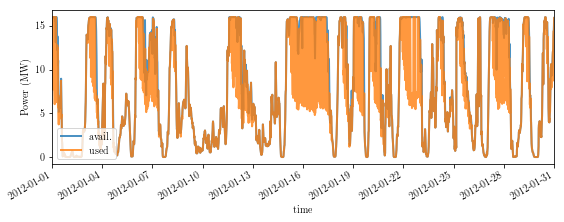

In [24]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

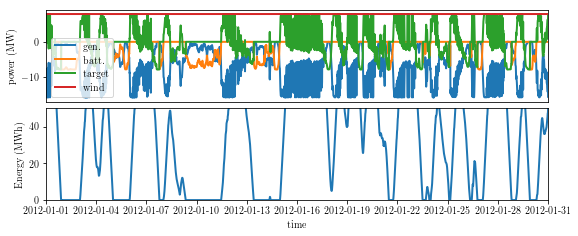

In [25]:
plot(MPC_robust_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'robust_mpc')

In [28]:
for (device, terminal) in MPC_robust_results.power.keys():
    flows.loc[device.name, 'robust MPC'] = np.mean(MPC_robust_results.power[(device, terminal)])
    #flows.loc[device.name, ('MPC, uncert. pred.','st. dev.')] = np.std(AR_MPC_results.power[(device, terminal)])
    
print(flows.to_latex(na_rep = '-', float_format=lambda x: '%.2fMW' % x))

for net in MPC_robust_results.price.keys():
    prices.loc[net.name, 'robust MPC'] = np.mean(MPC_robust_results.price[net])

print(prices.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

for (device, terminal) in MPC_robust_results.payments.keys():
    payments.loc[device.name, 'robust MPC'] = np.sum(MPC_robust_results.payments[(device, terminal)]) * len_interval
    
print(payments.to_latex(na_rep = '-', float_format=lambda x: '$%.0f' % x))

\begin{tabular}{lrrrr}
\toprule
{} &  prescient &  exact MPC &  uncert. MPC &  robust MPC \\
\midrule
Wind generator &    -7.04MW &    -6.99MW &      -6.09MW &     -6.58MW \\
Gas generator  &    -0.96MW &    -1.05MW &      -1.84MW &     -1.37MW \\
Storage        &    -0.00MW &     0.04MW &      -0.07MW &     -0.05MW \\
Target output  &     8.00MW &     8.00MW &       8.00MW &      8.00MW \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &  prescient &  exact MPC &  uncert. MPC &  robust MPC \\
\midrule
Net &        \$19 &        \$20 &          \$16 &         \$14 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &  prescient &  exact MPC &  uncert. MPC &  robust MPC \\
\midrule
Wind generator &    \$-52366 &    \$-66994 &      \$-26811 &     \$-32470 \\
Gas generator  &    \$-30658 &    \$-33718 &      \$-63111 &     \$-46838 \\
Storage        &    \$-31470 &    \$-17263 &       \$-3782 &      \$-6721 \\
Target output  &    \$114495 &    \$117974 &       